In [1]:
pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 364.4/364.4 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.5/233.5 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 3.1 MB/s eta 0:00:00


Importing necessary libraries

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report
import optuna
import pandas as pd
import seaborn as sns
import joblib

Loading the dataset

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                      download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                     download=True, transform=transform)

100%|██████████| 170M/170M [00:03<00:00, 52.6MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


Subset creation for classes deer and horse

In [4]:
train_mask = torch.tensor([(target == 7 or target == 4) for target in trainset.targets])
test_mask = torch.tensor([(target == 7 or target == 4) for target in testset.targets])

trainset.data = trainset.data[train_mask]
trainset.targets = torch.tensor(trainset.targets)[train_mask]
testset.data = testset.data[test_mask]
testset.targets = torch.tensor(testset.targets)[test_mask]

Converting to binary (1-Deer, 0-Horse)

In [5]:
trainset.targets = torch.tensor([1 if target == 4 else 0 for target in trainset.targets])
testset.targets = torch.tensor([1 if target == 4 else 0 for target in testset.targets])

In [6]:
generator=torch.Generator().manual_seed(42)

Splitting the dataset into training, test and validation

In [7]:
train_size = int(0.8 * len(trainset))
val_size = len(trainset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(trainset, [train_size, val_size],generator=generator)
print(len(train_dataset), len(val_dataset), len(testset))

8000 2000 2000


Class Distribution

Label
1    5000
0    5000
Name: count, dtype: int64


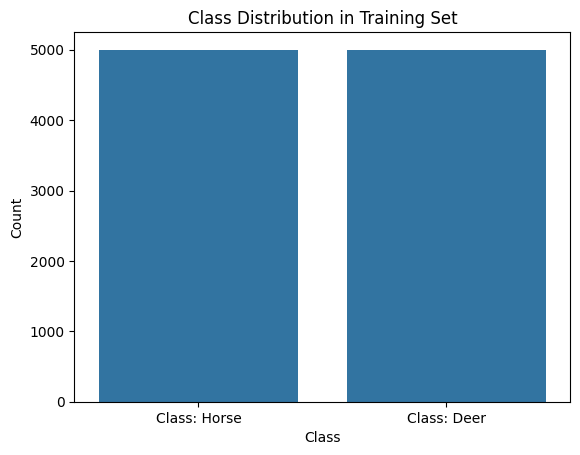

In [8]:
y_train = trainset.targets

df = pd.DataFrame({'Label': y_train})
print(df['Label'].value_counts())
sns.countplot(data=df, x='Label')
plt.title('Class Distribution in Training Set')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks([0, 1], ['Class: Horse', 'Class: Deer'])
plt.show()

In [9]:
print(f"Image shape: {trainset.data[0].shape}")
print(f"Image data type: {trainset.data.dtype}")

Image shape: (32, 32, 3)
Image data type: uint8


Displaying sample images

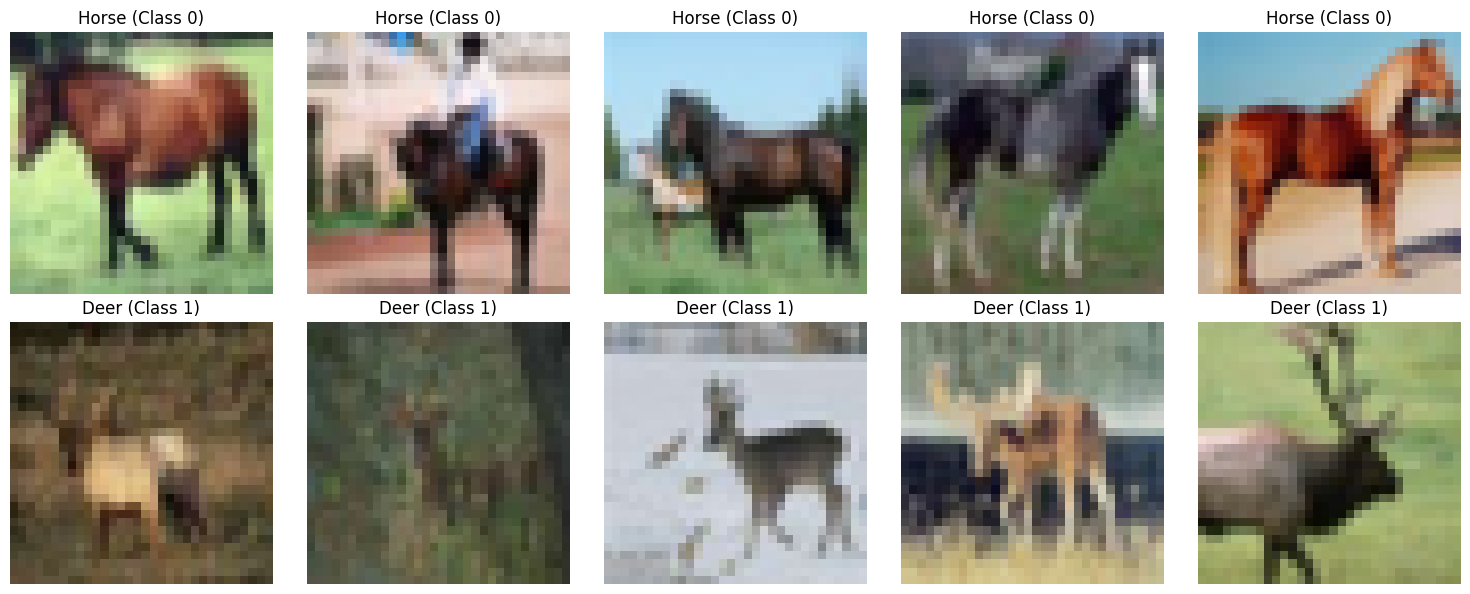

In [10]:
def plot_sample_images(dataset, num_samples=5):
    fig, axes = plt.subplots(2, num_samples, figsize=(15, 6))
    horse_idx = np.where(dataset.targets == 0)[0][:num_samples]
    deer_idx = np.where(dataset.targets == 1)[0][:num_samples]

    for i in range(num_samples):
        axes[0, i].imshow(dataset.data[horse_idx[i]])
        axes[0, i].set_title('Horse (Class 0)')
        axes[0, i].axis('off')

        axes[1, i].imshow(dataset.data[deer_idx[i]])
        axes[1, i].set_title('Deer (Class 1)')
        axes[1, i].axis('off')

    plt.tight_layout()
    plt.show()

plot_sample_images(trainset)


Initial Modelling of 3-Layer CNN

In [11]:
class CNN_3Layer(nn.Module):
    def __init__(self):
        super(CNN_3Layer, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc = nn.Linear(128 * 4 * 4, 1)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.pool(self.relu(self.conv3(x)))
        x = x.view(-1, 128 * 4 * 4)
        x = torch.sigmoid(self.fc(x))
        return x

In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Initial Parameters

In [13]:
learning_rate = 0.001
num_epochs = 30
batch_size = 64

In [14]:
model = CNN_3Layer().to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [15]:
train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [16]:
# Lists to store metrics
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

In [17]:
# Training loop
for epoch in range(num_epochs):
    # Training phase
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for data, target in train_loader:
        data, target = data.to(device), target.float().unsqueeze(1).to(device)

        optimizer.zero_grad()
        output = model(data)

        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        predicted = (output > 0.5).float()
        total += target.size(0)
        correct += (predicted == target).sum().item()

    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100 * correct / total
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc)

    # Validation phase
    model.eval()
    val_loss = 0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for data, target in val_loader:
            data, target = data.to(device), target.float().unsqueeze(1).to(device)
            output = model(data)

            loss = criterion(output, target)
            val_loss += loss.item()
            predicted = (output > 0.5).float()
            val_total += target.size(0)
            val_correct += (predicted == target).sum().item()

    val_loss = val_loss / len(val_loader)
    val_acc = 100 * val_correct / val_total
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(f'Epoch [{epoch+1}/{num_epochs}]:')
    print(f'Training Loss: {epoch_loss:.4f}, Training Accuracy: {epoch_acc:.2f}%')
    print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.2f}%')
    print('-' * 60)

Epoch [1/30]:
Training Loss: 0.5051, Training Accuracy: 74.30%
Validation Loss: 0.4243, Validation Accuracy: 79.80%
------------------------------------------------------------
Epoch [2/30]:
Training Loss: 0.3751, Training Accuracy: 83.20%
Validation Loss: 0.3068, Validation Accuracy: 87.30%
------------------------------------------------------------
Epoch [3/30]:
Training Loss: 0.3152, Training Accuracy: 86.40%
Validation Loss: 0.2647, Validation Accuracy: 89.00%
------------------------------------------------------------
Epoch [4/30]:
Training Loss: 0.2664, Training Accuracy: 89.08%
Validation Loss: 0.2548, Validation Accuracy: 89.15%
------------------------------------------------------------
Epoch [5/30]:
Training Loss: 0.2326, Training Accuracy: 90.82%
Validation Loss: 0.2406, Validation Accuracy: 89.65%
------------------------------------------------------------
Epoch [6/30]:
Training Loss: 0.2116, Training Accuracy: 91.42%
Validation Loss: 0.1591, Validation Accuracy: 94.50%

Initial model evaluation

In [19]:
def evaluate_model(model, test_loader, device):
    model.eval()
    y_true = []
    y_pred = []
    y_prob = []

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)

            y_true.extend(target.cpu().numpy())
            y_pred.extend((output.squeeze() > 0.5).float().cpu().numpy())
            y_prob.extend(output.squeeze().cpu().numpy())

    # Calculating metrics
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    roc_auc = auc(fpr, tpr)

    # Calculating per-class accuracy
    class_accuracies = []
    for i in range(2):
        mask = (np.array(y_true) == i)
        class_acc = np.mean(np.array(y_pred)[mask] == i) * 100
        class_accuracies.append(class_acc)

    print(classification_report(y_true, y_pred, target_names=['Horse', 'Deer']))

    return {
        'auc': roc_auc,
        'fpr': fpr,
        'tpr': tpr,
        'y_true': y_true,
        'y_pred': y_pred,
        'class_accuracies': class_accuracies
    }

ROC Curve and Per Class Accuracy

In [20]:
def plot_metrics(metrics):
    plt.figure(figsize=(12, 5))

    # ROC Curve
    plt.subplot(1, 2, 1)
    plt.plot(metrics['fpr'], metrics['tpr'],
             label=f'ROC curve (AUC = {metrics["auc"]:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()

    # Per-class Accuracy
    plt.subplot(1, 2, 2)
    plt.bar(['Horse (Class 0)', 'Deer (Class 1)'], metrics['class_accuracies'])
    plt.title('Per-class Accuracy')
    plt.ylabel('Accuracy (%)')
    for i, acc in enumerate(metrics['class_accuracies']):
        plt.text(i, acc + 1, f'{acc:.1f}%', ha='center')

    plt.tight_layout()
    plt.show()

              precision    recall  f1-score   support

       Horse       0.92      0.90      0.91      1000
        Deer       0.90      0.93      0.91      1000

    accuracy                           0.91      2000
   macro avg       0.91      0.91      0.91      2000
weighted avg       0.91      0.91      0.91      2000



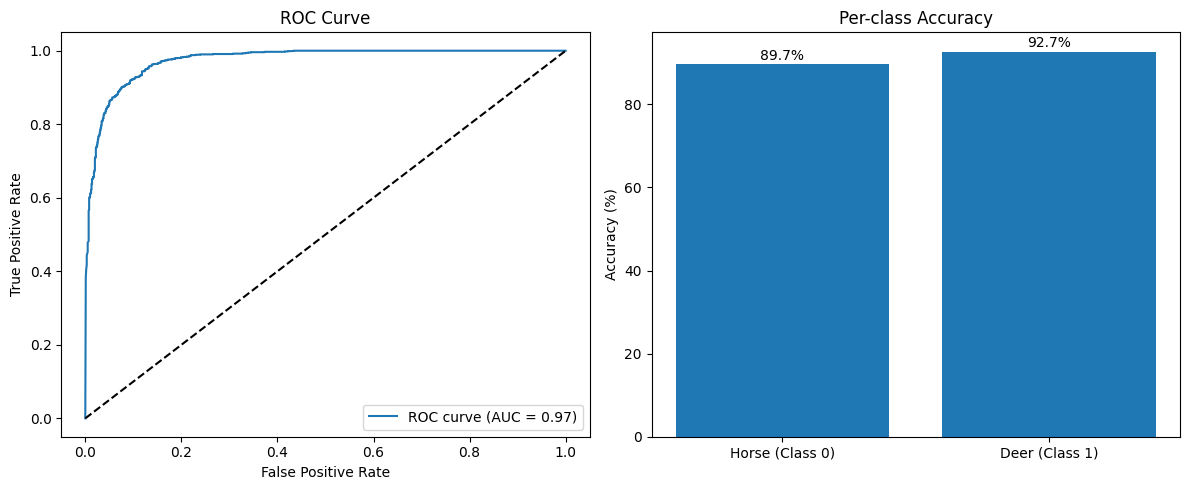

In [21]:
metrics = evaluate_model(model, test_loader, device)
plot_metrics(metrics)

Plots of Loss and ccuracy Curves over Epochs

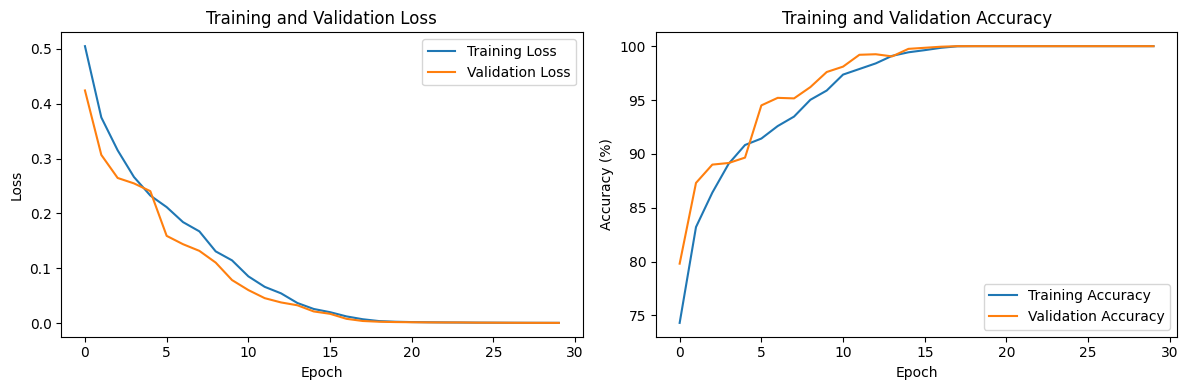

In [18]:
plt.figure(figsize=(12, 4))

# Plotting loss curves
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plotting accuracy curves
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

Confusion matrix

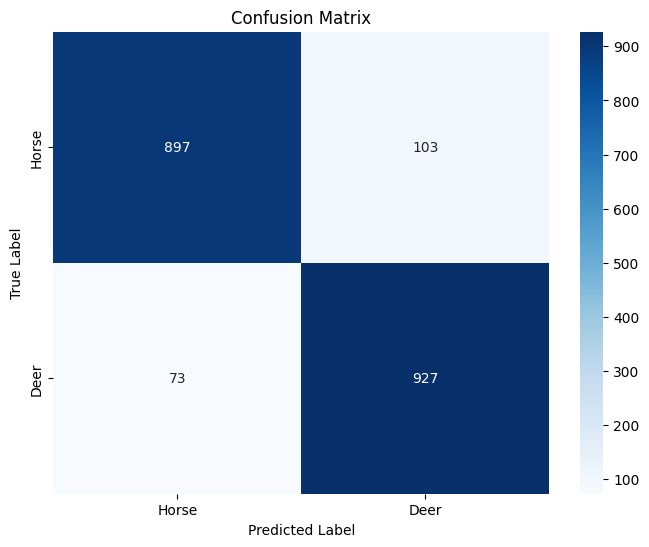

In [22]:
y_true = metrics['y_true']
y_pred = metrics['y_pred']
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Horse', 'Deer'],
            yticklabels=['Horse', 'Deer'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

Hyperparameter Tuning Using Optuna

In [29]:
class CNN_3Layer_HP(nn.Module):
    def __init__(self, n_filters1=32, n_filters2=64, n_filters3=128, dropout_rate=0.0):
        super(CNN_3Layer_HP, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, n_filters1, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(dropout_rate)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(n_filters1, n_filters2, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(dropout_rate)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(n_filters2, n_filters3, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(dropout_rate)
        )
        self.fc = nn.Linear(n_filters3 * 4 * 4, 1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = x.view(x.size(0), -1)
        x = torch.sigmoid(self.fc(x))
        return x

In [34]:
def objective(trial):
    # Hyperparameters to optimize
    n_filters1 = trial.suggest_categorical('n_filters1', [32, 64])
    n_filters2 = trial.suggest_categorical('n_filters2', [64, 128])
    n_filters3 = trial.suggest_categorical('n_filters3', [128, 256])
    dropout_rate = trial.suggest_float('dropout_rate', 0.0, 0.5)
    lr = trial.suggest_float('learning_rate', 1e-4, 1e-2, log=True)
    batch_size = trial.suggest_categorical('batch_size', [32, 64])

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    model = CNN_3Layer_HP(n_filters1, n_filters2, n_filters3, dropout_rate).to(device)
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # Training loop
    for epoch in range(30):
        # Training phase
        model.train()
        for data, target in train_loader:
            data, target = data.to(device), target.float().unsqueeze(1).to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()

        # Validation
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for data, target in val_loader:
                data, target = data.to(device), target.float().unsqueeze(1).to(device)
                output = model(data)
                predicted = (output > 0.5).float()
                total += target.size(0)
                correct += (predicted == target).sum().item()

        accuracy = correct / total
        trial.report(accuracy, epoch)

        if trial.should_prune():
            raise optuna.TrialPruned()

    return accuracy


In [35]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30)

[I 2024-12-03 03:27:06,327] A new study created in memory with name: no-name-946ea971-5e02-4cd9-bf51-187f8744551a
[I 2024-12-03 03:57:05,395] Trial 0 finished with value: 0.4925 and parameters: {'n_filters1': 64, 'n_filters2': 128, 'n_filters3': 256, 'dropout_rate': 0.4230653407379732, 'learning_rate': 0.0062412491479100435, 'batch_size': 32}. Best is trial 0 with value: 0.4925.
[I 2024-12-03 04:21:30,988] Trial 1 finished with value: 0.9115 and parameters: {'n_filters1': 64, 'n_filters2': 128, 'n_filters3': 128, 'dropout_rate': 0.12720662860746773, 'learning_rate': 0.0007824712308902543, 'batch_size': 32}. Best is trial 1 with value: 0.9115.
[I 2024-12-03 04:37:51,194] Trial 2 finished with value: 0.864 and parameters: {'n_filters1': 32, 'n_filters2': 128, 'n_filters3': 128, 'dropout_rate': 0.13318403895522513, 'learning_rate': 0.00675933067706061, 'batch_size': 64}. Best is trial 1 with value: 0.9115.
[I 2024-12-03 04:52:03,625] Trial 3 finished with value: 0.6085 and parameters: {'n

Best parameters post tuning

In [36]:
print("Best trial:")
trial = study.best_trial
print("  Value: ", trial.value)
print("  Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

Best trial:
  Value:  0.92
  Params: 
    n_filters1: 64
    n_filters2: 64
    n_filters3: 256
    dropout_rate: 0.34089234719463796
    learning_rate: 0.0004212614838221429
    batch_size: 32


Training final model on best parameters

In [49]:
best_params = study.best_trial.params
print("\nBest Parameters:", best_params)

# Creating final model with best parameters
final_model = CNN_3Layer_HP(
    n_filters1=best_params['n_filters1'],
    n_filters2=best_params['n_filters2'],
    n_filters3=best_params['n_filters3'],
    dropout_rate=best_params['dropout_rate']
).to(device)

train_loader = DataLoader(train_dataset, batch_size=best_params['batch_size'], shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=best_params['batch_size'], shuffle=False)
test_loader = DataLoader(testset, batch_size=best_params['batch_size'], shuffle=False)

criterion = nn.BCELoss()
optimizer = optim.Adam(final_model.parameters(), lr=best_params['learning_rate'])

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []
test_losses = []
test_accuracies = []

# Training loop
print("\nTraining final model with best parameters...")
for epoch in range(30):
    # Training phase
    final_model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for i, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.float().unsqueeze(1).to(device)

        optimizer.zero_grad()
        output = final_model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        predicted = (output > 0.5).float()
        total += target.size(0)
        correct += (predicted == target).sum().item()

    train_loss = running_loss / len(train_loader)
    train_acc = 100 * correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    # Validation phase
    final_model.eval()
    val_loss = 0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for data, target in val_loader:
            data, target = data.to(device), target.float().unsqueeze(1).to(device)
            output = final_model(data)
            loss = criterion(output, target)
            val_loss += loss.item()
            predicted = (output > 0.5).float()
            val_total += target.size(0)
            val_correct += (predicted == target).sum().item()

    val_loss = val_loss / len(val_loader)
    val_acc = 100 * val_correct / val_total
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    #Testing Phase
    final_model.eval()
    test_loss = 0
    test_correct = 0
    test_total = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.float().unsqueeze(1).to(device)
            output = final_model(data)
            loss = criterion(output, target)
            test_loss += loss.item()
            predicted = (output > 0.5).float()
            test_total += target.size(0)
            test_correct += (predicted == target).sum().item()

    test_loss = test_loss / len(test_loader)
    test_acc = 100 * test_correct / test_total
    test_losses.append(test_loss)
    test_accuracies.append(test_acc)

    print(f'Epoch [{epoch+1}/30]:')
    print(f'Training Loss: {train_loss:.4f}, Training Accuracy: {train_acc:.2f}%')
    print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.2f}%')
    print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.2f}%')
    print('-' * 60)


Best Parameters: {'n_filters1': 64, 'n_filters2': 64, 'n_filters3': 256, 'dropout_rate': 0.34089234719463796, 'learning_rate': 0.0004212614838221429, 'batch_size': 32}

Training final model with best parameters...
Epoch [1/30]:
Training Loss: 0.5686, Training Accuracy: 69.74%
Validation Loss: 0.4780, Validation Accuracy: 78.10%
Test Loss: 0.4696, Test Accuracy: 78.75%
------------------------------------------------------------
Epoch [2/30]:
Training Loss: 0.4522, Training Accuracy: 78.47%
Validation Loss: 0.4280, Validation Accuracy: 79.65%
Test Loss: 0.4222, Test Accuracy: 80.85%
------------------------------------------------------------
Epoch [3/30]:
Training Loss: 0.3877, Training Accuracy: 82.16%
Validation Loss: 0.3684, Validation Accuracy: 84.45%
Test Loss: 0.3543, Test Accuracy: 85.85%
------------------------------------------------------------
Epoch [4/30]:
Training Loss: 0.3614, Training Accuracy: 84.29%
Validation Loss: 0.3445, Validation Accuracy: 85.10%
Test Loss: 0.32

Final model evaluation

In [50]:
final_model.eval()
test_correct = 0
test_total = 0
y_true = []
y_pred = []
y_prob = []

with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.float().unsqueeze(1).to(device)
        output = final_model(data)
        predicted = (output > 0.5).float()

        test_total += target.size(0)
        test_correct += (predicted == target).sum().item()

        y_true.extend(target.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())
        y_prob.extend(output.cpu().numpy())


In [52]:
# Calculating final metrics
test_accuracy = 100 * test_correct / test_total
fpr, tpr, _ = roc_curve(y_true, y_prob)
roc_auc = auc(fpr, tpr)

# Calculating per-class accuracy
class_accuracies = []
for i in range(2):
    mask = (np.array(y_true) == i)
    class_acc = np.mean(np.array(y_pred)[mask] == i) * 100
    class_accuracies.append(class_acc)

# Printing final results
print("\nFinal Results:")
print(f"Test Accuracy: {test_accuracy:.2f}%")
print(f"ROC AUC: {roc_auc:.4f}")
print("\nPer-class Accuracy:")
print(f"Horse (Class 0): {class_accuracies[0]:.2f}%")
print(f"Deer (Class 1): {class_accuracies[1]:.2f}%")


Final Results:
Test Accuracy: 91.55%
ROC AUC: 0.9764

Per-class Accuracy:
Horse (Class 0): 88.20%
Deer (Class 1): 94.90%


Plotting Loss and Accuracy Curves over epochs and ROC Curve

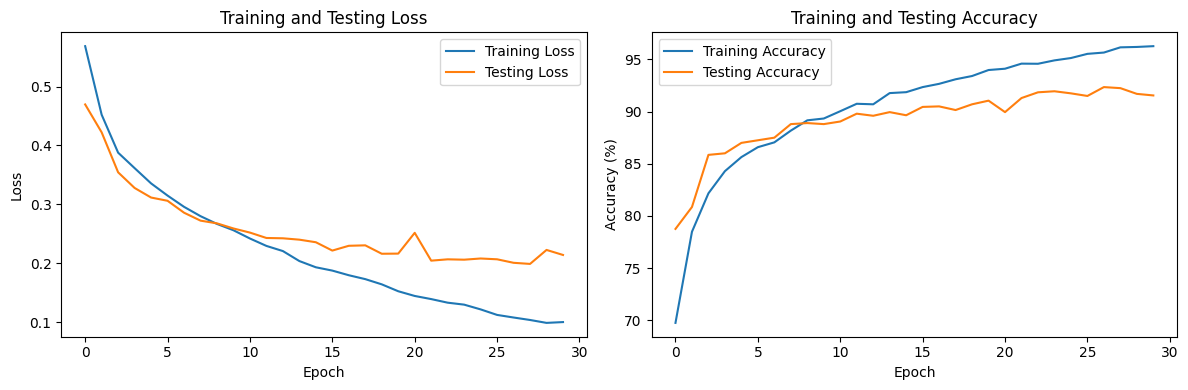

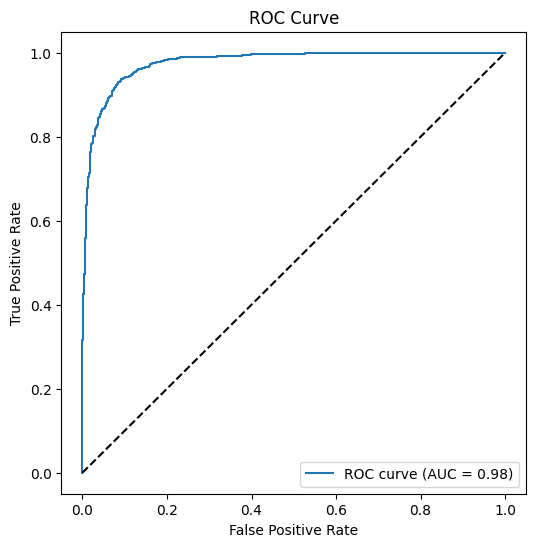

In [54]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Testing Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Testing Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(test_accuracies, label='Testing Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Testing Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

# Plotting ROC curve
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

Plot for Leaarning Rate Vs Accuracies

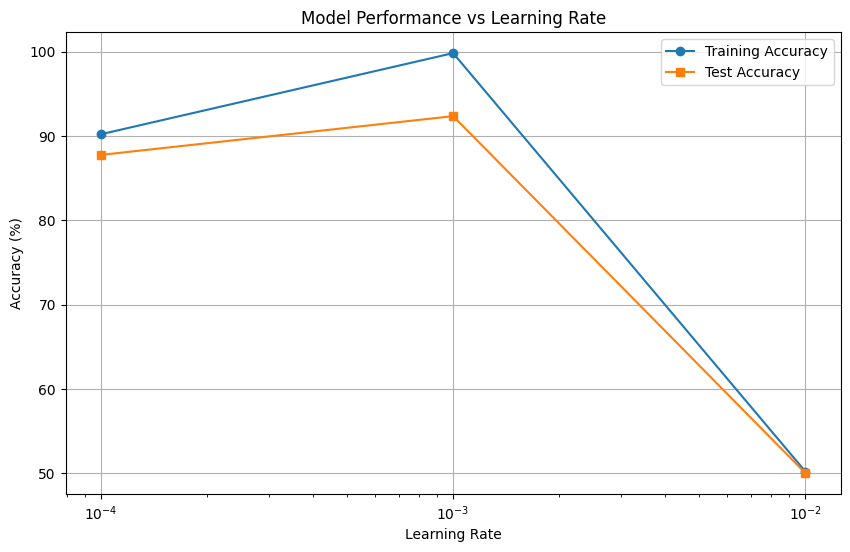

In [46]:
lr_results = {}
learning_rates = [1e-4, 1e-3, 1e-2]

for lr in learning_rates:
    model = CNN_3Layer_HP(
        n_filters1=best_params['n_filters1'],
        n_filters2=best_params['n_filters2'],
        n_filters3=best_params['n_filters3'],
        dropout_rate=best_params['dropout_rate']
    ).to(device)

    optimizer = optim.Adam(model.parameters(), lr=lr)
    lr_results[lr] = {'train_accs': [], 'test_accs': []}

    # Training loop
    for epoch in range(30):
        model.train()
        train_correct = 0
        train_total = 0

        for data, target in train_loader:
            data, target = data.to(device), target.float().unsqueeze(1).to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()

            predicted = (output > 0.5).float()
            train_total += target.size(0)
            train_correct += (predicted == target).sum().item()

    # Evaluation
    model.eval()
    with torch.no_grad():
        # Training accuracy
        train_correct = 0
        train_total = 0
        for data, target in train_loader:
            data, target = data.to(device), target.float().unsqueeze(1).to(device)
            output = model(data)
            predicted = (output > 0.5).float()
            train_total += target.size(0)
            train_correct += (predicted == target).sum().item()
        train_acc = 100 * train_correct / train_total

        # Test accuracy
        test_correct = 0
        test_total = 0
        for data, target in test_loader:
            data, target = data.to(device), target.float().unsqueeze(1).to(device)
            output = model(data)
            predicted = (output > 0.5).float()
            test_total += target.size(0)
            test_correct += (predicted == target).sum().item()
        test_acc = 100 * test_correct / test_total

    lr_results[lr]['train_accs'].append(train_acc)
    lr_results[lr]['test_accs'].append(test_acc)

plt.figure(figsize=(10, 6))
lrs = list(lr_results.keys())
train_means = [np.mean(lr_results[lr]['train_accs']) for lr in lrs]
test_means = [np.mean(lr_results[lr]['test_accs']) for lr in lrs]

plt.plot(lrs, train_means, marker='o', label='Training Accuracy')
plt.plot(lrs, test_means, marker='s', label='Test Accuracy')
plt.xscale('log')
plt.xlabel('Learning Rate')
plt.ylabel('Accuracy (%)')
plt.title('Model Performance vs Learning Rate')
plt.legend()
plt.grid(True)
plt.show()


Confusion matrix

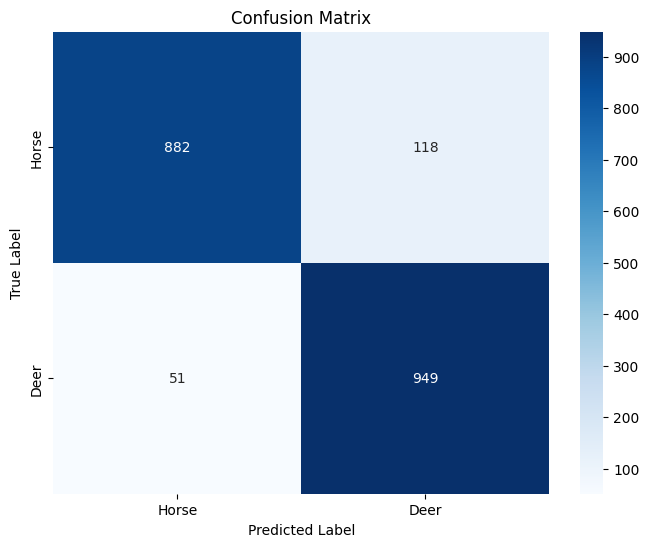

In [53]:
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Horse', 'Deer'],
            yticklabels=['Horse', 'Deer'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

Saving the final model

In [48]:
joblib.dump(final_model, 'final_model_CNN.joblib')